<a href="https://colab.research.google.com/github/Charlotte-99/Classifying_Cosmological_Data/blob/main/Alpha_map_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating an Alpha Map**

In this notebook we will create a map of alpha values predicted by our CNN models using the real CMB data

In [ ]:
!pip install healpy

     |████████████████████████████████| 15.8MB 201kB/s 


In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

from matplotlib.colors import ListedColormap

In [ ]:
import os

# Mount google drive folder with .fits maps
from google.colab import drive
drive.mount('/content/drive')

# Change directory
os.chdir('drive/MyDrive/Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

# **Extracting cutouts from the CMB**

In this section, we will extract 5x5 degree squares from the CMB across the entire map. First we will load and preview the Planck map.

/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/usr/local/lib/python3.7/dist-packages/healpy/fitsfunc.py:428: UserWarn

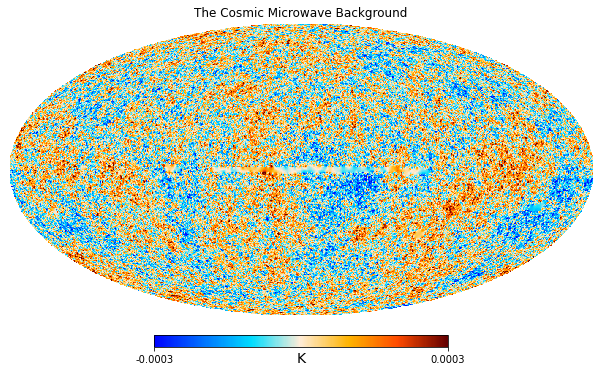

In [ ]:
# Import and plot map
map = hp.fitsfunc.read_map('COM_CMB_IQU-smica_2048_R3.00_full.fits')
cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

hp.mollview(map, title='The Cosmic Microwave Background', unit='K', cmap=cmap,
            min=-300e-6, max=300e-6)

Now we will create the list of longitude and latitude coordinates. These will be spaced out at 5 degree intervals.

Note that we are choosing the centres of the cutouts here, hence why we start at 2.5 longitude and not 0 longitude (and similarly with the latitude). This is so that it makes it easier to plot the map later on, as it avoids wrap-around issues (i.e. we'll be able to just plot an image that spans from 0 to 360 in width and 0 to 180 in height).

In [ ]:

# Create longitude and latitude list
lon_list = np.arange(-177.5, 182.5, 5)
lat_list = np.arange(-87.5, 92.5, 5)

coords = list(itertools.product(lon_list, lat_list))

In [ ]:
# print(coords)
print(len(coords))

2592


Now we define our extraction function. This is exactly the same as we used before.

In [ ]:
def extract_map(map, rot, deg_side, pixel_side):
  ''' This function extracts a map with shape (pixel_side, pixel_side) of a 
  deg_side x deg_side degree squared region from a map. 

  @params:
  map         a healpy map
  rot         a tuple (lon, lat, psi) where lon, lat specify where the
              centre of the extracted map will be and psi specifies a rotation.
              All in units of degrees.
  deg_side    number of degrees the side of the extracted map corresponds to
  pixel_side  size of the image side in pixels
  '''
  reso = 60*deg_side/pixel_side
  mini_map = hp.visufunc.gnomview(map, rot=rot, xsize=pixel_side,
                                  reso=reso, return_projected_map=True,
                                  no_plot=True)
  return mini_map

Now we can etxract the maps. We're not saving this to the Drive folder just to save on space (although it will mean we'll have to rerun this each time we open up the notebook).

In [ ]:
# Setup empty list to contain cutouts
num_maps = len(coords)
cutouts = [None]*num_maps

# Dimensions
pixel_side = 200
deg_side = 5

# Extract map
for n, (lon, lat) in enumerate(coords):
  cutouts[n] = extract_map(map, (lon, lat, 0), deg_side,
                             pixel_side)

# Convert to array and add channel dimension
cutouts = np.array(cutouts)
cutouts = cutouts[..., np.newaxis]

# **Running the cutouts through the model**

We can now load our model and create a dataset to output values of alpha.

In [ ]:
# Load model
model = tf.keras.models.load_model('regression_model_val_loss_0_2314')

In [ ]:
def batch_standardisation(maps):
  epsilon = 1e-10
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  denom = tf.math.sqrt(variance + epsilon)
  maps_standardised = (maps - mean)/denom
  return maps_standardised


Here we create our Planck dataset. We're still batching since we're using batch standardisation.

In [ ]:
planck_ds = tf.data.Dataset.from_tensor_slices((cutouts))
planck_ds = planck_ds.batch(16)
planck_ds = planck_ds.map(batch_standardisation)

Now we can save our predictions to a variable. This will contain the predicted value of $\alpha$ for each 'pixel'

In [ ]:
# Save predictions
predictions = model.predict(planck_ds)


In [ ]:
np.save('predictions_real_CMB.npy', predictions)

In [ ]:
predicted_alphas = predictions*1e-6


Here we begin setting up the array to contain our alpha values. First we create an array that has 180 rows and 360 columns.

We also modify our map coordinates to turn them into row/column indices to make plotting easier.

In [ ]:
alpha_map = np.zeros((180, 360))

plot_coords = np.array(coords)

# Add 177.5 from all longitude coordinates (so -177.5 becomes 0, etc.)
plot_coords[:, 0] += 177.5

# Add 87.5 to all latitude coordinates (so -87.5 becomes 0, etc.)
# This means our (0, 0) element of the array will correspond to (lon, lat) = (2.5, -87.5)
plot_coords[:, 1] += 87.5


We now go though the map and assign alpha values to each cell of the map array.

In [ ]:
# Colour in map in 5x5 blocks.
for n, (X, Y) in enumerate(plot_coords):
  alpha_map[int(Y):int(Y)+5, int(X):int(X)+5] = predicted_alphas[n]


Now we plot the map.

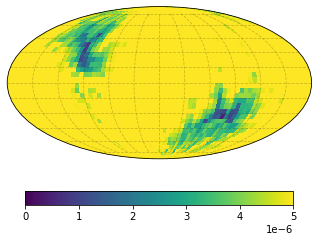

In [ ]:
ax = plt.axes(projection='mollweide')

# Lon, Lat coordinates
lon = np.flip(np.linspace(-np.pi, np.pi, 360))
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)

# Plot map
plot_map = ax.pcolormesh(Lon, Lat, alpha_map, vmin=0, vmax=5e-6)
plt.colorbar(plot_map, orientation='horizontal', shrink=0.8)

# Colorbar
ax.grid(color='black', alpha=0.2, linestyle='--')

x_labels = [item.get_text() for item in ax.get_xticklabels()]
x_empty_string_labels = ['']*len(x_labels)

y_labels = [item.get_text() for item in ax.get_xticklabels()]
y_empty_string_labels = ['']*len(y_labels)

ax.set_xticklabels(x_empty_string_labels)
ax.set_yticklabels(y_empty_string_labels)

#plt.savefig('Planck_Alpha_map_regression.png', dpi=300, figsize=(10, 8), bbox_inches='tight')


Experimenting with the CMB map in Healpy has led us to notice that the longitude behaves different to what we expected. All positive values of longitude are actually negative and vice versa, i.e. lon = -60 is actually lon = 60. Thus, when we plot the map, we need to take this into account by effectively flipping the longitudinal coordindates.

Latitude coordinates behave as expected, so this does not need to change.

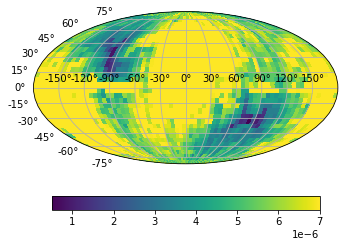

In [ ]:

ax = plt.axes(projection='mollweide')

lon = np.flip(np.linspace(-np.pi, np.pi, 360))
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)
avg_cmap = ax.pcolormesh(Lon, Lat, alpha_map, vmax=7e-6)
plt.colorbar(avg_cmap, orientation='horizontal', shrink=0.8)
plt.grid(True)
plt.savefig('alpha_map_max_7.png', dpi=300, figsize=(10, 8), bbox_inches='tight')